In [1]:
import geopops
import sys, platform, pathlib
import sciris as sc
import starsim as ss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

# Geopops

**GeoPops** is a package for generating geographically and demographically realistic synthetic populations for any US Census location using publicly available data. Population generation includes three steps:
1. Generate individuals within households using combinatorial optimization (CO)
2. Assign individuals to schools and workplace locations using enrollment data and commute flows
3. Connect individuals within locations using graph algorithms

Resulting files include a list of agents with attributes (e.g., age, gender, income) and networks detailing their connections within home, school, workplace, and group quarters (e.g., correctional facilities, nursing homes) locations. GeoPops is meant to produce reasonable approximations of state and county population characteristics with granularity down to the Census Block Group (CBG). GeoPops builds on a previous package, [GREASYPOP-CO](https://github.com/CDDEP-DC/GREASYPOP-CO/tree/main) (One Health Trust), and incorporates the following changes:
* All code wrapped in convenient Python package that can be pip installed
* Compatibility with Census data beyond 2019 (still developing)
* Automated data downloading
* Users can adjust all config parameters from the front-end
* Classes for using GeoPops with the agent-based modeling software [Starsim](https://starsim.org/) (IDM)

GeoPops is in development, and we welcome feedback. Please log any issues as you try it out.

## MIDAS 2025
This tutorial accompanies a speed talk and poster at the MIDAS 2025 annual symposium. It demonstrates:
1. Making a population of Howard County, MD
2. Running a Starsim SIR ABM on the population
3. Incorporating endogenous feedback for "school closures"
4. Tracking outcomes by demographic and geographic subgroups

### **This tutorial is a demonstration of the framework using a simple example of a generic upper respiratory infection.** 

For more realistic applications find me at the following conferences:

## Winter Simulation Conference 2025
**GeoPops: An open-source package for generating geographically realistic synthetic populations** (*Presentation*)
* More detailed methodology and usage
* Compare GeoPops to two other open-source synthetic population generators (UrbanPop and Geo-Synthetic-Pop)
  * Make three MD pops (one with each generator)
  * Compare individuals and homes to real Census data
  * Compare network stats of each home, school, and workplace network
  * Run Starsim COVID-19 model on each population
  * Compare simulation results to each other and observed data for first wave of pandemic
  * Discuss usability of each generator

## Epidemics 2025
**Modeling the impact of dynamic decision making on infectious disease outcomes by demographic and geographic subgroups: An open-source agent-based modeling framework** (*Poster*)
* Run Starsim COVID-19 model with utility framework on GeoPops population of MD
* Individuals weigh health-wealth trade-offs of staying home from work as a function of their income and age
* Test different policy scenarios (e.g., paid sick leave, cash transfer) and compare to observed data from first wave of pandemic
* Demographic and geographic subgroup outcome tracking 

# Tutorial
| Tutorial Section | Packages and Classes |
|------------------|----------------------|
| **1.0 Make Population** |  |
| 1.1 Define population parameters | geopops.WriteConfig() |
| 1.2 Download raw data | geopops.DownloadData() |
| 1.3 Preprocessing | geopops.ProcessData() |
| 1.4 Run Julia portion | geopops.RunJulia.run_all()  |
| 1.4.1 Combinatorial Optimization | geopops.RunJulia.CO() |
| 1.4.2 Assignment and network generation | geopops.RunJulia.SynthPop() |
| 1.4.3 Export to csv | geopops.RunJulia.Export() |
| **2.0 GeoPops for Starsim** |  |
| 2.1 People | geopops.ForStarsim.People() |
| 2.2 Networks | geopops.ForStarsim.GPNetwork() |
| 2.3 Subgroup Tracking | geopops.ForStarsim.SubgroupTracking() |
| **3.0 Starsim SIR model** |  |
| 3.1 Disease parameters | sciris.objdict() |
| 3.2 Custom intervention | starsim.Module() |
| 3.3 Run Sim | starsim.Sim() |
| **4.0 Plotting** |  |
| 4.1 Feedback vs no Feedback | matplotlib |
| 4.2 Infections by age group | matplotlib |
| 4.3 Cumulative infections by CBG | matplotlib |


# 1.0 Make population
First, set up Python and Julia environments and obtain a Census API key. See GeoPops [README.md](https://github.com/ACCIDDA/GeoPops) for instructions. The population can be generated with the following commands. The subsequent notebook sections go through each step with brief explanations.

In [ ]:
# pars_geopops = {'path': "YOUR_OUTPUT_DIR", # Set a folder where you want outut files to be stored
#                 'census_api_key': "YOUR_CENSUS_API_KEY", # Your Census API key
#                 'julia_env_path': "YOUR_JULIA_ENV_PATH", # Path to your Julia environment, "/Users/Name/.julia/environments/v1.9" or “C:/YOUR PATH TO JULIA/.julia/environments/v1.9/Project.toml” 
#                 'main_year': 2019, # Year of data
#                 'geos': ["24027"], # Example of Howard County, MD
#                 'commute_states': ["24"], # State fips of commute data to download
#                 'use_pums': ["24"]} # State fips of PUMS data to download

# geopops.WriteConfig(**pars_geopops) # Define parameters for pop generation in config.json
# geopops.DownloadData() # Download raw data
# geopops.ProcessData() # Preprocess data
# j = geopops.RunJulia() # Run Julia portion
# j.run_all() # Run all methods (CO(), SynthPop(), Export()) in  RunJulia() class

## 1.1 Define population parameters
The `WriteConfig()` class reads in a dictionary of population parameters and writes a `config.json` file referenced by other scripts. You can view parameters using `.get_pars()` and change any of these using WriteConfig(). 
* Census area you want to make your population
* Commute states
* Attributes (age, gender, race/ethnicity) to include
* Mean degree and assortativitity in networks
* And more

In [ ]:
pars_geopops = {'path': "YOUR_OUTPUT_DIR", # Set a folder where you want outut files to be stored
                'census_api_key': "YOUR_CENSUS_API_KEY", # Your Census API key
                'julia_env_path': "YOUR_JULIA_ENV_PATH", # Path to your Julia environment, "/Users/Name/.julia/environments/v1.9" or “C:/YOUR PATH TO JULIA/.julia/environments/v1.9/Project.toml” 
                'main_year': 2019, # Year of data
                'geos': ["24027"], # Example of Howard County, MD
                'commute_states': ["24"], # State fips of commute data to download
                'use_pums': ["24"]} # State fips of PUMS data to download

c = geopops.WriteConfig(**pars_geopops)
# c.get_pars() # View parameters from config.json

Updated config.json with new parameters


## 1.2 Download raw data
The `DownloadData()` class pulls raw data files from the internet using the Census API and urls. The `pipeline()` method prints out data sources and output folders. Output files go into the folders census, geo, pums, school, work. `folders_files_tree.rtf` shows how all the files are stored in your output directory.
* American Community Survey
* Decennial Census
* Public Use Microdata Samples
* National Center for Education Statistics
* Longitudinal Employer Household Dynamics
* And more

Runtime for Howard County is about 2-4 minutes on a MacBook Pro (1.4 GHz Quad-Core Intel Core i5). Downloading school data especially takes a while so be patient. You may want set your computer not to go to sleep in case this breaks the run.

In [ ]:
d = geopops.DownloadData()
# d.pipeline() # View raw data sources, files, and output folders

## 1.3 Preprocessing
The `ProcessData()` class reformats all the raw data for the next steps in Julia. Output files go into the folder processed.

Runtime for Howard County is about 2 minutes on my laptop.

In [ ]:
geopops.ProcessData()

## 1.4 Run Julia portion
The `RunJulia()` class consists of three methods, which can be run separately or all together (sequentially) using `.run_all()`. Each one calls and runs the corresponding Julia scripts. For a more detailed explanation of the methods for each step, see [Tulchinsky et al. 2024](https://arxiv.org/abs/2406.14698).
1. `.CO()` - Combinatorial Optimization
2. `.SynthPop()` - School/workplace assignment and network generation
3. `.Export()` - Exports mtx files to csv

### 1.4.1 Combinatorial optimization
GeoPops uses combinatorial optimization to sample households from the Public Use Microdata Samples (PUMS) until a set is found that reasonably approximates population characteristics from the American Comunity Survey (ACS).

**PUMS:** Anonymized subset of Census survey responses for regions of around 100,000 people. Contains compositional details of households and members (e.g., the number of five-member households with school-age children).

**ACS:** Geography and demographics at CBG level. Restricted to select summaries of marginal counts (e.g., how many households in a locale have five members and how many have school-age children). Missing compositional details. 

The distributional characteristics of agents in a PUMS area would not be representative of the overall population area. CO is a way to generate agents within households so that the distributions for demographic characteristics (age, income, gender) of the overall population reasonably match ACS data.

Runtime is about 5 minutes (MacBook Pro, 1.4 GHz Quad-Core Intel Core i5)

In [ ]:
j = geopops.RunJulia()
j.CO()

### 1.4.2 Assignment and network generation
The `.SynthPop()` method performs school and workplace assignment and network generation. Output files go into the folder pop_export. Networks are stored as upper adjacency matrices in .mtx format. 

**Assignment**
|  | Methods | Data | Data Sources |
| -------- | -------- | -------- | -------- |
| Schools | Students assigned to closest school that offer required grade. Teachers assigned to school by selecting teachers from nearby CBGs | Student and staff counts for each grade level in public schools | National Center for Education Statistics (NCES) |
| Workplaces | Iterative proportional fitting (IPF) to make origin-destination commute matrix. IPF to make industry by destination commute matrix for each origin CBG. Includes outside workers | Origin-destination and workplace category matrices | Longitudinal Employer-Household Dynamics (LEHD) |

**Network generation** 
| Network | Algorithm | Parameters |
| -------- | -------- | -------- |
| Household | All agents within a household are fully connected |  |
| School | Stochastic Block Model within each school | Assortativity ⍺=0.9. Mean degree K=12. Blocks are grade levels (Pre-k – 12) |
| Workplace | Stochastic Block Model within each workplace | Assortativity ⍺=0.9. Mean degree K=8. Blocks are income levels (<40k or ≥ 40k) |
| Group quarters (GQ) | Watts-Strogatz Model within each GQ facility | Mean degree K=12. Rewiring probability β=0.25 |

Runtime is about 1.5 minutes (MacBook Pro, 1.4 GHz Quad-Core Intel Core i5).

In [ ]:
j.SynthPop()

### 1.4.3 Export to csv
The `.Export()` method exports jlse files as csv files into the folder pop_export.

Runtime is about 30 seconds (MacBook Pro, 1.4 GHz Quad-Core Intel Core i5).

In [ ]:
j.Export() # export to csv

# 2.0 GeoPops for Starsim
Starsim ([Kerr et al. 2024](https://starsim.org/)) is an open-source agent-based modeling software by the Institute for Disease Modeling. It is module-based, allowing the user to customize the disease, contact structure, and population.

The `geopops.ForStarsim()` class has three nested classes for formatting a GeoPops population for Starsim.
* `.People()` creates a Starsim people object of agents and attributes.
* `.GPNetwork()` transforms the upper adjacency matrices into a Starsim Network.
* `.SubgroupTracking()` returns a dataframe of outcomes overtime by subgroup. 

## 2.1 People 

In [3]:
ppl = geopops.ForStarsim.People()
# ppl = ss.load('pop_export/starsim/ppl.pkl') # If you already have a people object
sim = ss.Sim(people=ppl).init()
sim.people.to_df().head()

Creating Starsim People object from GeoPops data


/Users/Alisa/Library/CloudStorage/OneDrive-JohnsHopkins/Research/GeoPops_all/geopops/.venv/lib/python3.12/site-packages/starsim/utils.py:89: RuntimeWarning: 
Overwriting existing ndict entry "age"
  ss.warn(f'Overwriting existing ndict entry "{key}"')
/Users/Alisa/Library/CloudStorage/OneDrive-JohnsHopkins/Research/GeoPops_all/geopops/.venv/lib/python3.12/site-packages/starsim/utils.py:89: RuntimeWarning: 
Overwriting existing ndict entry "female"
  ss.warn(f'Overwriting existing ndict entry "{key}"')


Initializing sim with 426595 agents
Starsim People object created and saved successfully
Initializing sim with 426595 agents


,uid,slot,alive,age,female,ti_dead,ti_removed,scale,agegroup,race,cbg_id,state,county,wrk,worker,ses,vul,hsl
0,0,0,True,52.0,1.0,NaN,NaN,1.0,5.0,2.0,121.0,24.0,24027.0,0.0,0.0,NaN,1.0,1.0
1,1,1,True,11.0,1.0,NaN,NaN,1.0,1.0,2.0,93.0,24.0,24027.0,0.0,0.0,NaN,1.0,2.0
2,2,2,True,42.0,1.0,NaN,NaN,1.0,4.0,2.0,124.0,24.0,24027.0,0.0,0.0,NaN,1.0,0.0
3,3,3,True,33.0,0.0,NaN,NaN,1.0,3.0,2.0,53.0,24.0,24027.0,1.0,1.0,2.0,1.0,0.0
4,4,4,True,24.0,1.0,NaN,NaN,1.0,2.0,2.0,78.0,24.0,24027.0,1.0,1.0,2.0,1.0,1.0


## 2.2 Networks
`ForStarsim.GPNetwork()` reformats the upper adjacency matrices (mtx files) for each network into dataframes (also saved as csv files), where `p1` (person 1) is connected to `p2` (person 2) and `beta` is the weight of their connection (NOT the transmission coefficient). The link between the two agents is bi-directional so if either is infected, they could infect the other. The Starsim network beta is a multiplier in the transmission equation, so increasing beta in one network relative to others would increase transmissions in that network relative to others.

In [4]:
h = geopops.ForStarsim.GPNetwork(name='homenet', beta_value=1.0)
s = geopops.ForStarsim.GPNetwork(name='schoolnet', beta_value=1.0)
w = geopops.ForStarsim.GPNetwork(name='worknet', beta_value=1.0)
g = geopops.ForStarsim.GPNetwork(name='gqnet', beta_value=1.0)

sim = ss.Sim(people=ppl, networks=[h,s,w,g]).init()
sim.networks.schoolnet.edges

Network csv files created and saved successfully
Initializing sim with 426595 agents


#0. 'p1':   uids([   270,    359,    409, ..., 314264, 314264, 314264])
#1. 'p2':   uids([   214,    220,    183, ..., 265652, 270671, 296788])
#2. 'beta': array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

## 2.3 Subgroup Tracking
The `geopops.ForStarsim.SubgroupTracking()` class allows you to track any outcome by any subgroup using the starsim Analyzer class. The SubgroupTracking analyzers can be passed into a Starsim model allowing you to return a dataframe where the rows are subgroups, columns are time-steps, and values are the specified outcome (infections, deaths).

In [5]:
cbg_tracking = geopops.ForStarsim.SubgroupTracking(subgroup='cbg_id', outcome='infected', name='cbg_tracking')
age_tracking = geopops.ForStarsim.SubgroupTracking(subgroup='agegroup', outcome='infected', name='age_tracking')

# 3.0 Starsim SIR model

## 3.1 Disease parameters
The following parameter dictionary can be passed into the Sim object to create a model that has an SIR disease structure, a run time of 50 days, initial prevalence of 0.001, transmission coefficient (beta) of 0.1, and infection duration of 7 days. While this is a simple example, you can customize your Starsim model to varying degrees of complexity. For example, creating new disease compartments, varying disease parameters by agent attribute or network, or seeding infections to specific agents. 

Our presentations at **Winter Simulation Conference** and **Epidemics** provide more realistic models with a COVID-19 disease structure, age-based disease parameters, and infection seeding by geography.

In [6]:
# Define epidemic parameters
pars_ss = sc.objdict(start = 0, stop=50, # number of days to run the simulation
                    verbose = 0, # 0 = no output, 1 = print progress, 2 = print detailed progress
                    rand_seed = 123, # random seed
                    diseases = dict(type = 'sir', # type of disease
                                    init_prev = 0.01, # initial prevalence
                                    beta = 0.1, # transmission rate (same for each network for now, but could make different)
                                    dur_inf = 7, # duration of infection
                                    ))

## 3.2 Custom intervention
Starsim allows you to design custom interventions (e.g., vaccination) that can be passed into a sim. Here we create a module called `Feedback` which "turns off" the school network when prevalence crosses 0.1. This is a **simple** intervention and only meant to show how endgogenous human behavior can be incorporated. 

In our poster at **Epidemics** we incorporate a more realistic application using a utility framework where people weight the health-wealth trade-offs in the decision to stay home from work (including a work from home option). 

In [7]:
class Feedback(ss.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.has_product = False  
        return

    def step(self):
        sim = self.sim
        n_infected = np.count_nonzero(self.sim.people.sir.infected)
        n_alive = len(self.sim.people.alive)
        prev = n_infected / n_alive
        if prev > 0.1:
            sim.networks.schoolnet.edges.beta = np.zeros(len(sim.networks.schoolnet.edges.beta))
        else:
            sim.networks.schoolnet.edges.beta = np.ones(len(sim.networks.schoolnet.edges.beta))
        return

## 3.3 Run Sim
Now tie all this together by passing the people object, network, analyzers, and intervention into the Starsim sim object. Run one sim without the Feedback module and one sim with the Feedback module to compare results.

Runtime is about 45 seconds (MacBook Pro, 1.4 GHz Quad-Core Intel Core i5).

In [8]:
# Run sim without feedback module
sim1 = ss.Sim(pars_ss, # Dictionary of disease parameters
              people=ppl, # People object created with geopops.Starsim.People()
              networks=[h,s,w,g], # Networks object created with geopops.Starsim.Networks()
              analyzers=[age_tracking, cbg_tracking] # Analyzers object created with geopops.Starsim.SubgroupTracking()
              ).run(verbose=False) # verbose=False to exclude output printing
res1 = sim1.results

# Run sim with feedback module
sim2 = ss.Sim(pars_ss, 
              people=ppl, 
              networks=[h,s,w,g], 
              analyzers=[age_tracking, cbg_tracking], 
              interventions=Feedback() # Custom intervention created using ss.Module()
              ).run(verbose=False)
res2 = sim2.results

/Users/Alisa/Library/CloudStorage/OneDrive-JohnsHopkins/Research/GeoPops_all/geopops/.venv/lib/python3.12/site-packages/numba/cpython/hashing.py:477: UserWarning: FNV hashing is not implemented in Numba. See PEP 456 https://www.python.org/dev/peps/pep-0456/ for rationale over not using FNV. Numba will continue to work, but hashes for built in types will be computed using siphash24. This will permit e.g. dictionaries to continue to behave as expected, however anything relying on the value of the hash opposed to hash as a derived property is likely to not work as expected.
  warnings.warn(msg)


# 4.0 Plotting
## 4.1 Feedback vs no Feedback

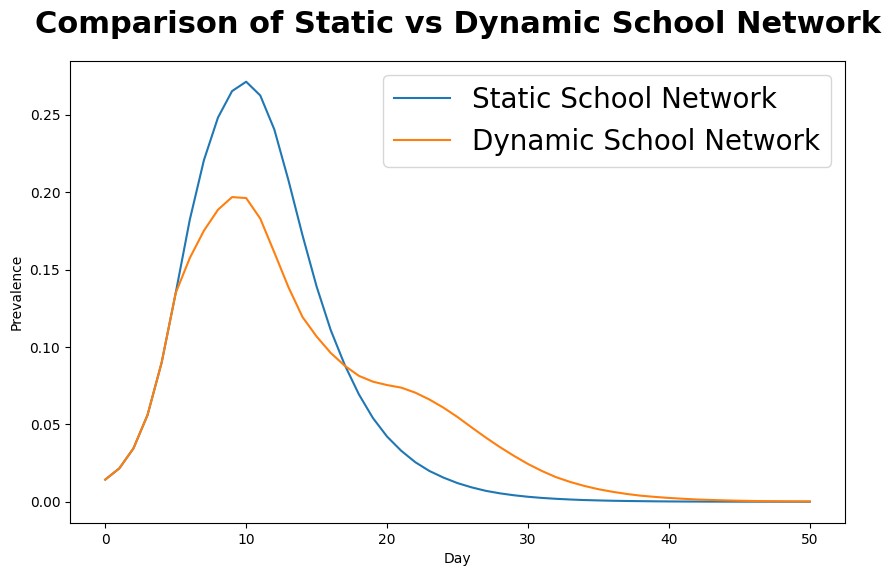

In [9]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(res1.timevec, res1.sir.prevalence, label='Static School Network')
plt.plot(res2.timevec, res2.sir.prevalence, label='Dynamic School Network')
plt.ylabel('Prevalence')
plt.xlabel('Day')
plt.title('Comparison of Static vs Dynamic School Network', fontsize=22, fontweight='bold', pad=20)
plt.legend(fontsize=20)
plt.savefig(f'{pars_geopops['path']}/figures/comparison_static_dynamic_school_network.png')
plt.show()

## 4.2 Infections by Age group

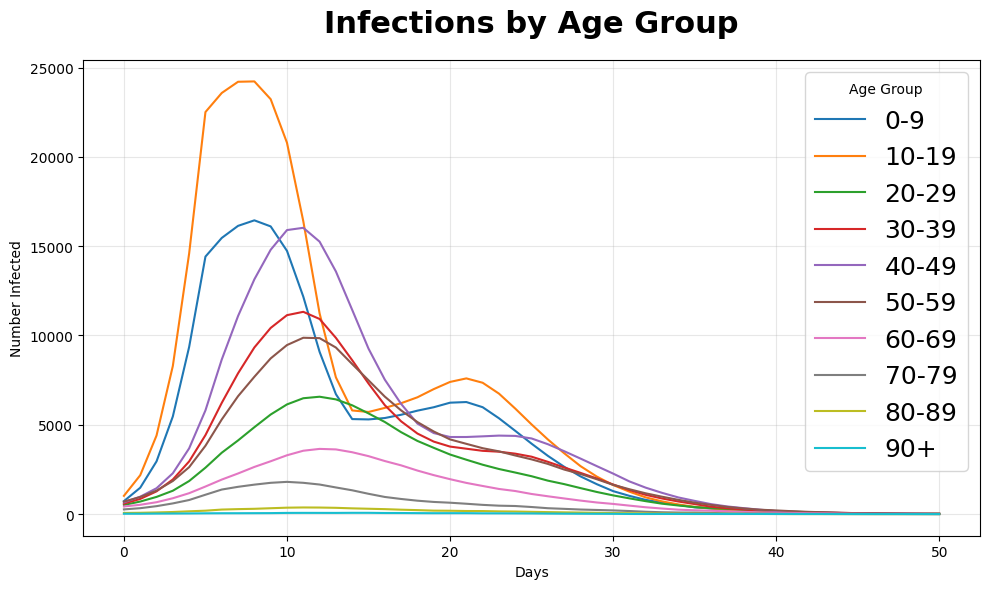

In [10]:
# sim2.analyzers[0] returns the first analyzer as a dataframe
# Drop the last row because it's all NaN (people who live outside Howard County do not have age data)
agegroup_df = sim2.analyzers[0].get_subgroup_data().iloc[:-1] 

# Create age group label mapping
age_labels = {
    0: "0-9",
    1: "10-19", 
    2: "20-29",
    3: "30-39",
    4: "40-49",
    5: "50-59",
    6: "60-69",
    7: "70-79",
    8: "80-89",
    9: "90+"
}

# Set the subgroup column as index and transpose
df_plot = agegroup_df.set_index('agegroup').T

# Plot
plt.figure(figsize=(10, 6))
for col in df_plot.columns:
    agegroup_num = int(col)
    age_label = age_labels.get(agegroup_num, f"Age Group {agegroup_num}")
    plt.plot(range(len(df_plot)), df_plot[col], label=age_label)

plt.xlabel('Days')
plt.ylabel('Number Infected')
plt.title('Infections by Age Group', fontsize=22, fontweight='bold', pad=20)
plt.legend(title='Age Group', loc='upper right', fontsize=18)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{pars_geopops['path']}/figures/infections_by_age_group.png')
plt.show()

## 4.3 Total infections per 100 population by CBG

In [20]:
cbg_df = sim2.analyzers[1].get_subgroup_data() # Returns second analyzer (cbg_tracking) as dataframe
ppl_df = sim.people.to_df() # map cbg_id to population per cbg
ppl_df = ppl_df.groupby('cbg_id').size().reset_index()
ppl_df = ppl_df.rename(columns={0: 'pop'})
cbg_df = cbg_df.merge(ppl_df, on='cbg_id', how='left').reset_index()                             
cbg_df['tot_cum_inf'] = cbg_df.drop('cbg_id', axis=1).sum(axis=1) # Sum infections across all days
cbg_df['tot_inf_p100'] = cbg_df['tot_cum_inf'] / cbg_df['pop'] * 100
len(cbg_df['tot_cum_inf'].unique()) # Number of unique CBG with infections
inf_per_cbg = cbg_df[['cbg_id', 'pop', 'tot_cum_inf', 'tot_inf_p100']] # Keep only cbg_id and infections
cbg_idxs = pd.read_csv('pop_export/cbg_idxs.csv') # map cbg_id to cbg_geocode
inf_per_cbg = cbg_idxs.merge(inf_per_cbg, on='cbg_id', how='left')
inf_per_cbg['cbg_geocode'].dtype

cbg_shp = gpd.read_file('geo/tl_2019_24_bg.shp')
cbg_shp['cbg_geocode'] = cbg_shp['GEOID'].astype(int)
cbg_shp['cbg_geocode'].dtype
cbg_shp = cbg_shp.merge(inf_per_cbg, on='cbg_geocode', how='left')
# cbg_shp.head(100)

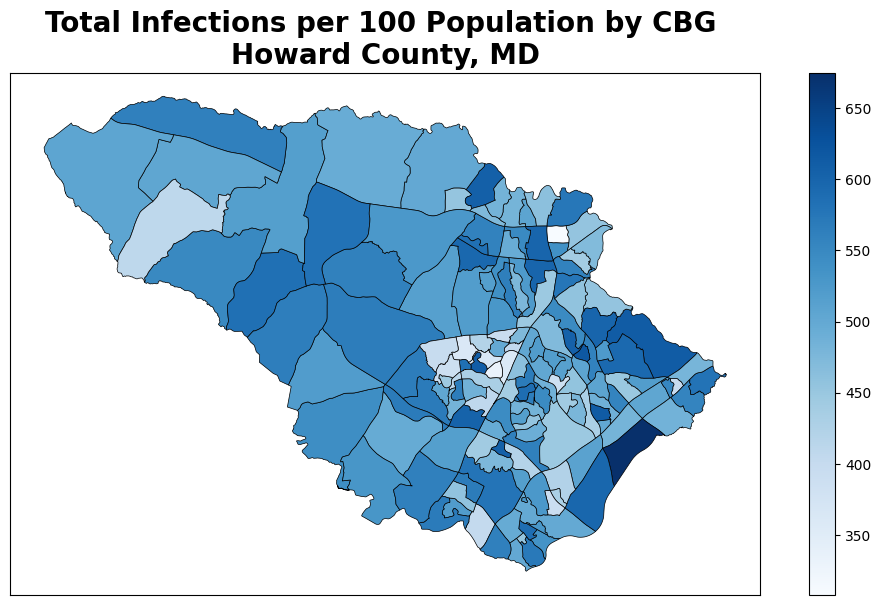

In [21]:
# Create the map
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot the map with tot_cum_inf as the color
cbg_shp.plot(column='tot_inf_p100', 
               cmap='Blues',  # Red color scheme (darker = more infections)
               legend=True,
               ax=ax,
               edgecolor='black',
               linewidth=0.5)

# Customize the plot
ax.set_title('Total Infections per 100 Population by CBG \nHoward County, MD', fontsize=20, fontweight='bold')

# Remove axis ticks for cleaner look
ax.set_xticks([])
ax.set_yticks([])

# Add a colorbar with better formatting
cbar = ax.get_figure().get_axes()[1]  # Get the colorbar
cbar.set_label('Total Infections per 100 Population')

plt.tight_layout()
plt.savefig(f'{pars_geopops['path']}/figures/infections_by_cbg.png')
plt.show()


## 4.4 Population by CBG

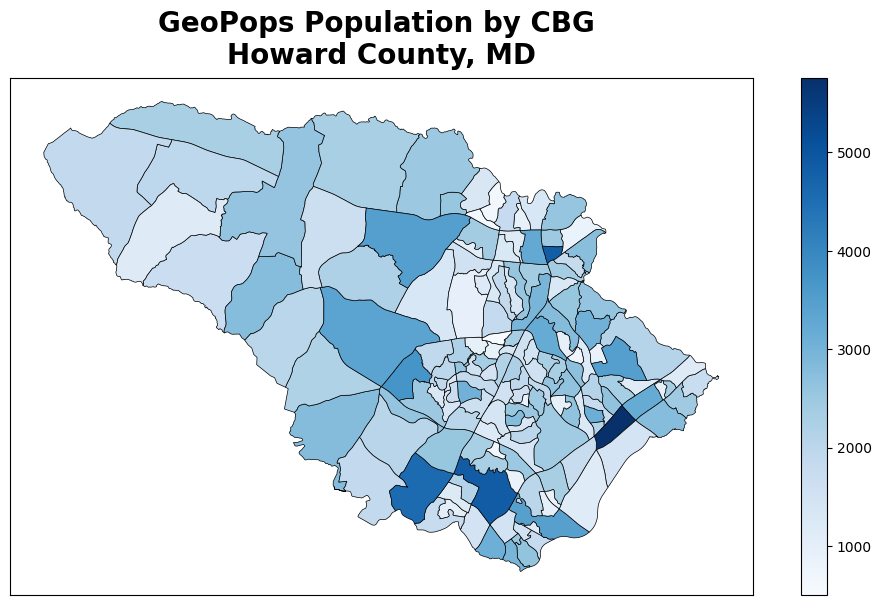

In [22]:
# Create the map
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot the map with tot_cum_inf as the color
cbg_shp.plot(column='pop', 
               cmap='Blues',  # Red color scheme (darker = more infections)
               legend=True,
               ax=ax,
               edgecolor='black',
               linewidth=0.5)

# Customize the plot
ax.set_title('GeoPops Population by CBG \nHoward County, MD', fontsize=20, fontweight='bold', pad=10)

# Remove axis ticks for cleaner look
ax.set_xticks([])
ax.set_yticks([])

# Add a colorbar with better formatting
cbar = ax.get_figure().get_axes()[1]  # Get the colorbar

plt.tight_layout()
plt.savefig(f'{pars_geopops['path']}/figures/population_by_cbg.png')
plt.show()

# 4.5 Plot of Maryland counties

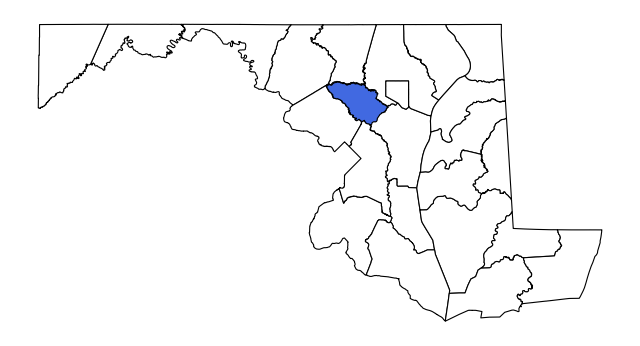

In [23]:
# Build county geometries from CBGs
counties = cbg_shp.dissolve(by='COUNTYFP', as_index=False)

# Howard County (FIPS 027)
howard = cbg_shp[cbg_shp['COUNTYFP'] == '027'].dissolve()
fig, ax = plt.subplots(figsize=(8, 8))
# Draw all counties in white with black outlines
counties.plot(ax=ax, facecolor='white', edgecolor='black', linewidth=0.8)
# Overdraw Howard County in blue
howard.plot(ax=ax, color='royalblue', edgecolor='black', linewidth=0.8)
ax.set_axis_off()
plt.savefig(f'{pars_geopops['path']}/figures/maryland_counties.png',transparent=True)
plt.show()

# Why is this cool?!
**Open-source, user-friendly framework for capturing demographic and geographic differences in human behavior and health outcomes during respiratory epidemics.**

* Reasonably realistic geographic and demographic granularity for night and day time activities 
* Don't have to build a model from scratch
* Can be used by state and county health departments for context-specific scenario modeling
  * Seed infections to a specific geography
  * Target interventions to specific demographic or geographic groups
* There are several research groups already using Starsim to model respiratory diseases that can now use GeoPops as well
* **Inform decisions about targeted interventions, which can lead to more efficient resource use and reductions in  overall disease burden and disparities**

# Areas for development
* Dynamic populations (right now static)
* Incorporating private schools and hopsitals (and other things)
* Other public health modeling outside respiratory infectious diseases (STIs, NCDs)
* Make agents 'agentic' with LLMs

# Questions

* **https://github.com/ACCIDDA/GeoPops**

* **pip install geopops** and go through tutorial. Log issues! Please by patient :)

* **Winter Simulation Conference:** GeoPops: An open-source package for generating geographically realistic synthetic populations

* **Epidemics:** Modeling the impact of dynamic decision making on infectious disease outcomes by demographic and geographic subgroups: An open-source agent-based modeling framework

